<a href="https://colab.research.google.com/github/ayuko66/akiya-lens/blob/model_accuracy/notebook/akiya_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Task
Load the data from "/content/drive/MyDrive/Colab Notebooks/ml_projects/akiya-lens/features_master__wide__v1.csv", define the columns '2018_出生率[‰]', '2018_年少人口率[%]', '2018_死亡率[‰]', '2018_生産年齢人口率[%]', '2018_転入超過率[‰]', '2018_高齢化率[%]', '2023_出生率[‰]', '2023_年少人口率[%]', '2023_死亡率[‰]', '2023_生産年齢人口率[%]', '2023_転入超過率[‰]', '2023_高齢化率[%]', 'スーパー密度[件/km²]', '2023年総人口あたりのスーパー密度', '住宅地価_log中央値_2018', '住宅地価_log中央値_2023', '学校密度[件/km²]', '2023年総人口あたりの学校密度', '平均気温', '年最深積雪', '年降水量', '病院密度[件/km²]', '2023年総人口あたりの病院密度', '駅密度[件/km²]', '2023年総人口あたりの駅密度' as features and '空き家率_2023' as the target variable. Predict the target variable using LightGBM with cross-validation for splitting the data into training and testing sets. Visualize the model interpretation using SHAP.

## データ読み込み

### Subtask:
指定されたCSVファイルをDataFrameとして読み込みます。


**Reasoning**:
Load the data from the specified CSV file into a pandas DataFrame and display the first few rows to verify the loading.



In [37]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ml_projects/akiya-lens/features_master__wide__v1.csv")
display(df.head())

,市区町村コード,市区町村名,都道府県名,2018_15〜64歳人口,2018_15歳未満人口,2018_65歳以上人口,2018_出生数,2018_出生率[‰],2018_年少人口率[%],2018_死亡数,...,2023_転入者数,2023_転出者数,2023_高齢化率[%],2023_年少人口率[%],2023_生産年齢人口率[%],2023_出生率[‰],2023_死亡率[‰],2023_転入率[‰],2023_転出率[‰],2023_転入超過率[‰]
0,15100,新潟市,新潟県,474664.0,96925.0,225184.0,NaN,NaN,12.164694,NaN,...,26679.0,27252.0,29.982440,11.726587,58.290973,NaN,NaN,34.220825,34.955805,-0.734980
1,15101,北区,新潟県,44081.0,9034.0,22055.0,443.0,5.893309,12.018092,837.0,...,1881.0,2120.0,31.995530,11.446980,56.557490,4.828785,14.031070,25.951271,29.248641,-3.297370
2,15102,東区,新潟県,82565.0,16847.0,38400.0,1091.0,7.916582,12.224625,1466.0,...,4360.0,4806.0,29.473246,11.676157,58.850597,5.909814,13.849036,32.411055,35.726498,-3.315443
3,15103,中央区,新潟県,109398.0,20897.0,46330.0,1382.0,7.824487,11.831281,1995.0,...,9175.0,9056.0,27.132032,11.375431,61.492537,6.303100,12.456946,52.669346,51.986223,0.683123
4,15104,江南区,新潟県,40429.0,9022.0,19622.0,508.0,7.354538,13.061544,826.0,...,2199.0,2259.0,29.937593,12.734757,57.327649,6.592248,13.653277,32.214116,33.093083,-0.878966


In [46]:
features = [
    '2018_出生率[‰]', '2018_年少人口率[%]', '2018_死亡率[‰]', '2018_生産年齢人口率[%]', '2018_転入超過率[‰]',
    '2018_高齢化率[%]', '2023_出生率[‰]', '2023_年少人口率[%]', '2023_死亡率[‰]', '2023_生産年齢人口率[%]',
    '2023_転入超過率[‰]', '2023_高齢化率[%]', 'スーパー密度[件/km²]', '2023年総人口あたりのスーパー密度',
    '住宅地価_log中央値_2018', '住宅地価_log中央値_2023', '学校密度[件/km²]', '2023年総人口あたりの学校密度',
    '平均気温', '年最深積雪', '年降水量', '病院密度[件/km²]', '2023年総人口あたりの病院密度',
    '駅密度[件/km²]', '2023年総人口あたりの駅密度', '空き家率_2018'
]
target = '空き家率_2023'

X = df[features]
y = df[target]

In [48]:
for col in ['駅密度[件/km²]', '病院密度[件/km²]', '学校密度[件/km²]', 'スーパー密度[件/km²]']:
    X[col+'_isna'] = X[col].isna().astype(int)

/tmp/ipython-input-3800758867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col+'_isna'] = X[col].isna().astype(int)
/tmp/ipython-input-3800758867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col+'_isna'] = X[col].isna().astype(int)
/tmp/ipython-input-3800758867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [49]:
X.head(10)

,2018_出生率[‰],2018_年少人口率[%],2018_死亡率[‰],2018_生産年齢人口率[%],2018_転入超過率[‰],2018_高齢化率[%],2023_出生率[‰],2023_年少人口率[%],2023_死亡率[‰],2023_生産年齢人口率[%],...,年降水量,病院密度[件/km²],2023年総人口あたりの病院密度,駅密度[件/km²],2023年総人口あたりの駅密度,空き家率_2018,駅密度[件/km²]_isna,病院密度[件/km²]_isna,学校密度[件/km²]_isna,スーパー密度[件/km²]_isna
0,NaN,12.164694,NaN,59.573304,-0.696560,28.262002,NaN,11.726587,NaN,58.290973,...,NaN,0.020144,0.000059,0.016641,0.000049,12.9446,0,0,0,0
1,5.893309,12.018092,11.134761,58.641745,-4.403352,29.340162,4.828785,11.446980,14.031070,56.557490,...,NaN,NaN,NaN,NaN,NaN,9.3668,1,1,1,1
2,7.916582,12.224625,10.637680,59.911328,-0.493426,27.864047,5.909814,11.676157,13.849036,58.850597,...,NaN,NaN,NaN,NaN,NaN,12.7208,1,1,1,1
3,7.824487,11.831281,11.295117,61.938004,-0.951168,26.230715,6.303100,11.375431,12.456946,61.492537,...,1780.6,0.096350,0.000098,0.039673,0.000040,16.9009,0,0,0,0
4,7.354538,13.061544,11.958363,58.530830,2.215048,28.407627,6.592248,12.734757,13.653277,57.327649,...,NaN,NaN,NaN,NaN,NaN,7.4002,1,1,1,1
5,6.696083,12.468390,12.385818,57.187645,1.238582,30.343964,5.175138,11.975244,14.353437,55.949434,...,NaN,NaN,NaN,NaN,NaN,11.1401,1,1,1,1
6,6.483769,11.811927,11.798694,60.047636,-4.300459,28.140438,4.664629,11.429491,14.522393,57.549576,...,NaN,NaN,NaN,NaN,NaN,10.9404,1,1,1,1
7,7.205271,12.586012,10.416799,59.099755,1.850604,28.314234,5.820939,12.350541,13.222397,57.856019,...,1765.5,0.013827,0.000039,0.020740,0.000058,12.5517,0,0,0,0
8,5.155617,10.887145,13.725321,58.118803,-5.741874,30.994051,4.251222,10.206566,15.478807,55.314936,...,1794.4,0.000000,0.000000,0.005588,0.000055,10.9981,0,0,0,0
9,6.791171,12.250454,12.909080,57.923277,-2.575962,29.826269,5.429837,11.621443,14.901717,56.799809,...,2578.7,0.004541,0.000019,0.015438,0.000064,12.5901,0,0,0,0


In [52]:
isna_cols = ['駅密度[件/km²]_isna', '病院密度[件/km²]_isna', '学校密度[件/km²]_isna', 'スーパー密度[件/km²]_isna']
for col in isna_cols:
    if col in X.columns:
        proportion_of_ones = X[col].mean() * 100
        print(f"{col} の '1' の割合: {proportion_of_ones:.2f}%")
    else:
        print(f"Warning: Column '{col}' not found in DataFrame X.")

駅密度[件/km²]_isna の '1' の割合: 8.44%
病院密度[件/km²]_isna の '1' の割合: 8.44%
学校密度[件/km²]_isna の '1' の割合: 8.44%
スーパー密度[件/km²]_isna の '1' の割合: 8.44%


In [53]:
df['OSM_missing'] = df[['駅密度[件/km²]', 'スーパー密度[件/km²]',
                     '病院密度[件/km²]', '学校密度[件/km²]']].isna().all(axis=1).astype(int)

## 交差検証のためのデータ分割

### Subtask:
学習データとテストデータを交差検証用に分割します。


**Reasoning**:
Instantiate a KFold object and generate train/test indices for cross-validation.



In [60]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_indices = list(kf.split(X))

In [61]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

models = []
oof_predictions = np.zeros(len(df))


# Function to sanitize feature names
def sanitize_feature_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        new_col = col.replace('[', '_').replace(']', '_').replace('<', '_')
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# Drop the isna_cols before sanitizing
isna_cols = ['駅密度[件/km²]_isna', '病院密度[件/km²]_isna', '学校密度[件/km²]_isna', 'スーパー密度[件/km²]_isna']
X = X.drop(columns=isna_cols, errors='ignore')


X_sanitized = sanitize_feature_names(X.copy())
feature_importances = pd.DataFrame(index=X_sanitized.columns)


for fold, (train_index, test_index) in enumerate(fold_indices):
    print(f"Fold {fold+1}/{kf.n_splits}")
    X_train, X_test = X_sanitized.iloc[train_index], X_sanitized.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lgb_params = {
        'objective': 'regression_l1',
        'metric': 'rmse',
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'n_jobs': -1,
        'seed': 42 + fold,
        'boosting_type': 'gbdt',
    }

    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              eval_metric='rmse',
              callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)])

    models.append(model)
    oof_predictions[test_index] = model.predict(X_test)
    feature_importances[f'fold_{fold+1}'] = model.feature_importances_

rmse = np.sqrt(mean_squared_error(y, oof_predictions))
print(f"\nOverall RMSE: {rmse}")

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Overall RMSE: 6.220043046020341


In [62]:
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'oof_predictions' contains the out-of-fold predictions from the previous step
# And 'y' contains the true target values

rmse = np.sqrt(mean_squared_error(y, oof_predictions))
r2 = r2_score(y, oof_predictions)

print(f"Overall RMSE: {rmse}")
print(f"Overall R-squared: {r2}")

Overall RMSE: 6.220043046020341
Overall R-squared: 0.35912593772211276


In [63]:
!apt-get -y install fonts-ipafont-gothic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [64]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fm.fontManager.addfont('/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf')
plt.rcParams['font.family'] = 'IPAPGothic'

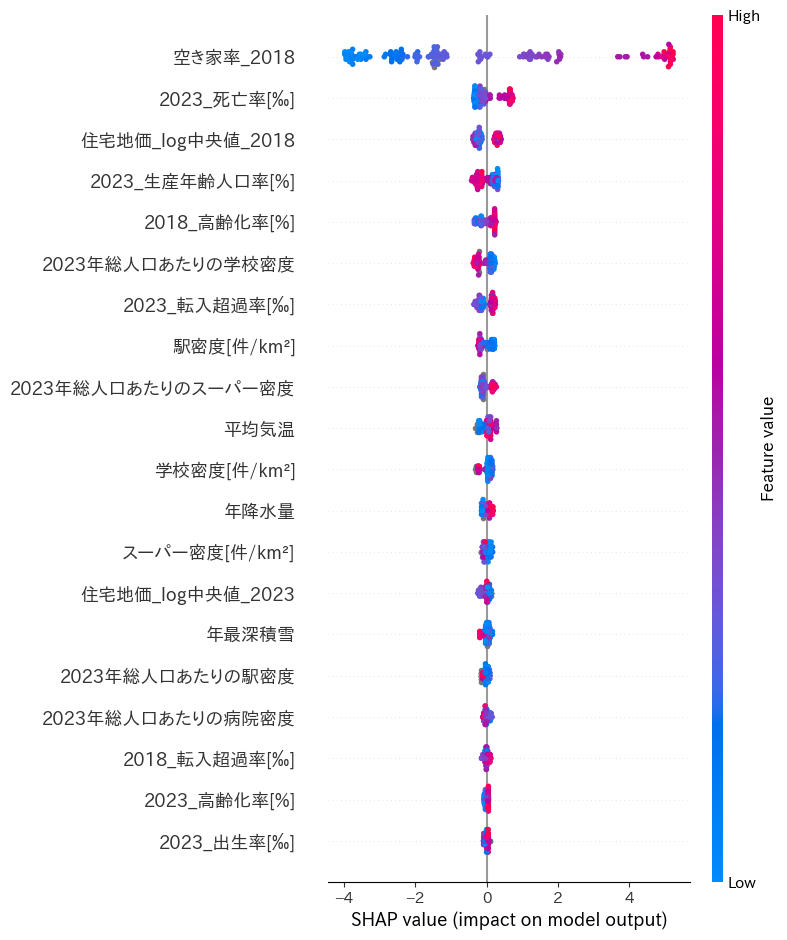

In [65]:
# Install shap if not already installed
!pip install shap

import shap

# Use the first trained model for SHAP explanation
explainer = shap.TreeExplainer(models[0])
shap_values = explainer.shap_values(X_sanitized)

# Visualize the SHAP results (summary plot)
shap.summary_plot(shap_values, X_sanitized, feature_names=X.columns)

これで日本語が表示されるはずです。SHAPのプロットを再度実行してみてください。

## 各市区町村の空き家率の期待値 (予測値)

### Subtask:
各市区町村について、モデルが予測した空き家率の期待値（予測値）を表示します。

**Reasoning**:
Display the original DataFrame along with the out-of-fold predictions, showing the predicted vacancy rate for each municipality.

In [45]:
df_with_predictions = df.copy()
df_with_predictions['predicted_空き家率_2023'] = oof_predictions

display(df_with_predictions[['市区町村名', '空き家率_2023', 'predicted_空き家率_2023']].head())

,市区町村名,空き家率_2023,predicted_空き家率_2023
0,新潟市,13.12,12.017480
1,北区,9.49,10.965779
2,東区,12.61,13.208075
3,中央区,16.36,14.408640
4,江南区,9.22,13.884752


## 実際の空き家率と予測された空き家率の比較

### Subtask:
実際の空き家率とモデルが予測した空き家率を散布図で比較します。

**Reasoning**:
Create a scatter plot to visualize the relationship between the actual and predicted vacancy rates, which helps in understanding the model's performance.

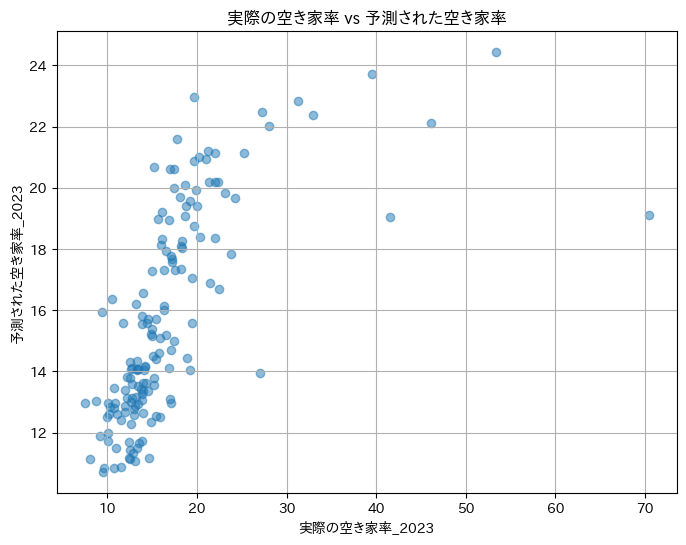

In [66]:
plt.figure(figsize=(8, 6))
plt.scatter(y, oof_predictions, alpha=0.5)
plt.xlabel("実際の空き家率_2023")
plt.ylabel("予測された空き家率_2023")
plt.title("実際の空き家率 vs 予測された空き家率")
plt.grid(True)
plt.show()

## 'OSM_missing' 列を削除してモデルを再学習し精度を比較

### Subtask:
データから 'OSM_missing' 列を削除し、LightGBM モデルを再学習して精度を評価します。

**Reasoning**:
Drop the 'OSM_missing' column from the DataFrame, redefine the features and target, and then repeat the cross-validation and model training process.

In [67]:
# Drop the 'OSM_missing' column from the original DataFrame
df_dropped_osm = df.drop(columns=['OSM_missing'], errors='ignore')

# Redefine features and target with the modified DataFrame
features_dropped_osm = [
    '2018_出生率[‰]', '2018_年少人口率[%]', '2018_死亡率[‰]', '2018_生産年齢人口率[%]', '2018_転入超過率[‰]',
    '2018_高齢化率[%]', '2023_出生率[‰]', '2023_年少人口率[%]', '2023_死亡率[‰]', '2023_生産年齢人口率[%]',
    '2023_転入超過率[‰]', '2023_高齢化率[%]', 'スーパー密度[件/km²]', '2023年総人口あたりのスーパー密度',
    '住宅地価_log中央値_2018', '住宅地価_log中央値_2023', '学校密度[件/km²]', '2023年総人口あたりの学校密度',
    '平均気温', '年最深積雪', '年降水量', '病院密度[件/km²]', '2023年総人口あたりの病院密度',
    '駅密度[件/km²]', '2023年総人口あたりの駅密度'
]
target_dropped_osm = '空き家率_2023'

X_dropped_osm = df_dropped_osm[features_dropped_osm]
y_dropped_osm = df_dropped_osm[target_dropped_osm]

# Sanitize feature names
X_dropped_osm_sanitized = sanitize_feature_names(X_dropped_osm.copy())


# Perform cross-validation and model training
models_dropped_osm = []
oof_predictions_dropped_osm = np.zeros(len(df_dropped_osm))
feature_importances_dropped_osm = pd.DataFrame(index=X_dropped_osm_sanitized.columns)


kf_dropped_osm = KFold(n_splits=5, shuffle=True, random_state=42)
fold_indices_dropped_osm = list(kf_dropped_osm.split(X_dropped_osm_sanitized))


for fold, (train_index, test_index) in enumerate(fold_indices_dropped_osm):
    print(f"Fold {fold+1}/{kf_dropped_osm.n_splits}")
    X_train, X_test = X_dropped_osm_sanitized.iloc[train_index], X_dropped_osm_sanitized.iloc[test_index]
    y_train, y_test = y_dropped_osm.iloc[train_index], y_dropped_osm.iloc[test_index]

    lgb_params = {
        'objective': 'regression_l1',
        'metric': 'rmse',
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'n_jobs': -1,
        'seed': 42 + fold,
        'boosting_type': 'gbdt',
    }

    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              eval_metric='rmse',
              callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)])

    models_dropped_osm.append(model)
    oof_predictions_dropped_osm[test_index] = model.predict(X_test)
    feature_importances_dropped_osm[f'fold_{fold+1}'] = model.feature_importances_

rmse_dropped_osm = np.sqrt(mean_squared_error(y_dropped_osm, oof_predictions_dropped_osm))
r2_dropped_osm = r2_score(y_dropped_osm, oof_predictions_dropped_osm)


print(f"\n--- Results after dropping 'OSM_missing' ---")
print(f"Overall RMSE: {rmse_dropped_osm}")
print(f"Overall R-squared: {r2_dropped_osm}")

print(f"\n--- Comparison with previous results ---")
print(f"Previous Overall RMSE: {rmse}")
print(f"Previous Overall R-squared: {r2}")

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

--- Results after dropping 'OSM_missing' ---
Overall RMSE: 7.103751471129125
Overall R-squared: 0.16408632035855641

--- Comparison with previous results ---
Previous Overall RMSE: 6.220043046020341
Previous Overall R-squared: 0.35912593772211276


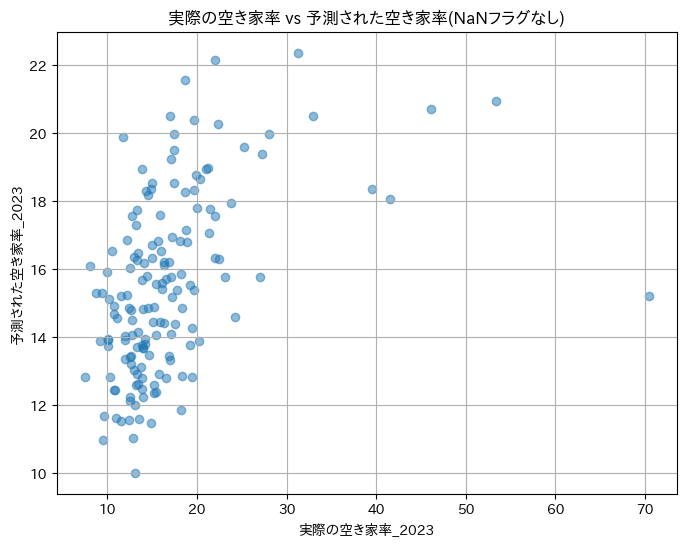

In [68]:
plt.figure(figsize=(8, 6))
plt.scatter(y_dropped_osm, oof_predictions_dropped_osm, alpha=0.5)
plt.xlabel("実際の空き家率_2023")
plt.ylabel("予測された空き家率_2023")
plt.title("実際の空き家率 vs 予測された空き家率(NaNフラグなし)")
plt.grid(True)
plt.show()

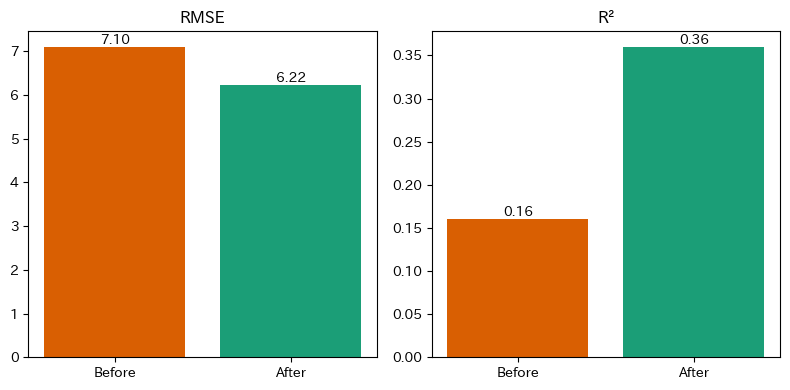

In [69]:
import matplotlib.pyplot as plt

metrics = {
    "RMSE": [7.10, 6.22],
    "R²": [0.16, 0.36]
}
labels = list(metrics.keys())

fig, axes = plt.subplots(1, 2, figsize=(8,4))
for i, (metric, values) in enumerate(metrics.items()):
    axes[i].bar(["Before", "After"], values, color=["#d95f02","#1b9e77"])
    axes[i].set_title(metric)
    for j, v in enumerate(values):
        axes[i].text(j, v, f"{v:.2f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()